# Bilevel ROF Scalar Parameter Learning
In this notebook we will propose an optimal parameter learning methodology for getting the optimal parameter for the scalar ROF image denoising model.

$$
\min \|\bar{u}-z\|^2 + \frac{\alpha}{2}\|\lambda\|^2\\
\text{s.t. }\langle \bar{u},v-\bar{u} \rangle + \lambda\|\mathbb{K}v\|_{2,1} - \lambda\|\mathbb{K}\bar{u}\|_{2,1} \ge \langle f,v-\bar{u} \rangle
$$

where $\|\cdot\|_{2,1}$ is the Total Variation seminorm.

In [1]:
using LinearAlgebra, StructuredOptimization, AbstractOperators, Plots, Distributed, Images, ImageQualityIndexes

## Cost Function and Lower Level Solver

In [171]:
# Lower Level Solver
function lower_level_solver(u,f,λ,K)
    @minimize ls(-K'*u+f) + conj(λ*norm(u,2,1,2)) with ForwardBackward(tol = 1e-4, gamma = 1/8, fast = true) 
    return -K'*(~u)+f
end

# Upper level cost
function upper_level_cost(u,z,λ,α)
    return 0.5*norm(u[:]-z[:])^2 + 0.5*α*norm(λ)^2
end

upper_level_cost (generic function with 1 method)

In [209]:
m,n = 64,64
f = tril(ones(m,n)) + 0.4*randn(m,n)
f[f .< 0] .= 0.
f[f .> 1] .= 1.
z = tril(ones(m,n));

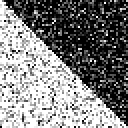

In [210]:
Gray.(f)

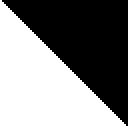

In [211]:
Gray.(z)

In [214]:
step = 0.1
lambda_min = eps()
lambda_max = 9

K = Variation(size(f))
u = Variable(size(K,1)...)
α = 1e-2

lambda_range = lambda_min:step:lambda_max
costs = Float64[]
ssims = Float64[]
@distributed for λ in lambda_range
    u_h = lower_level_solver(u,f,λ,K)
    push!(costs,upper_level_cost(u_h,z,λ,α))
    push!(ssims,ssim(u_h,z))
    print("$(round(λ,digits=3)), ")
end

0.0, 0.1, 0.2, 0.3, 

Task (runnable) @0x0000000112b62890

0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1.0, 1.1, 1.2, 1.3, 1.4, 1.5, 1.6, 1.7, 1.8, 1.9, 2.0, 2.1, 2.2, 2.3, 2.4, 2.5, 2.6, 2.7, 2.8, 2.9, 3.0, 3.1, 3.2, 3.3, 3.4, 3.5, 3.6, 3.7, 3.8, 3.9, 4.0, 4.1, 4.2, 4.3, 4.4, 4.5, 4.6, 4.7, 4.8, 4.9, 5.0, 5.1, 5.2, 5.3, 5.4, 5.5, 5.6, 5.7, 5.8, 5.9, 6.0, 6.1, 6.2, 6.3, 6.4, 6.5, 6.6, 6.7, 6.8, 6.9, 7.0, 7.1, 7.2, 7.3, 7.4, 7.5, 7.6, 7.7, 7.8, 7.9, 8.0, 8.1, 8.2, 8.3, 8.4, 8.5, 8.6, 8.7, 8.8, 8.9, 9.0, 

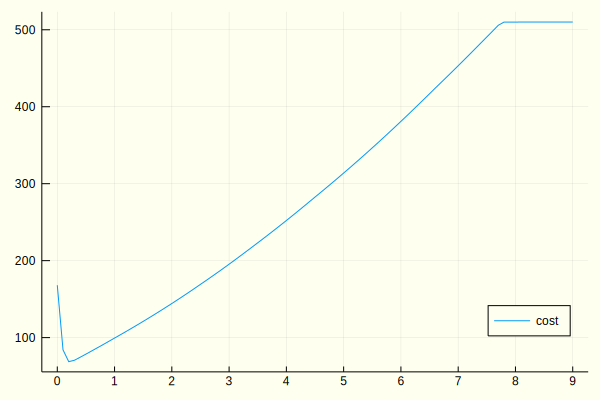

In [215]:
plot(lambda_range,costs,label="cost",xticks = 0:1:lambda_max, background_color = :ivory, legend=:bottomright)

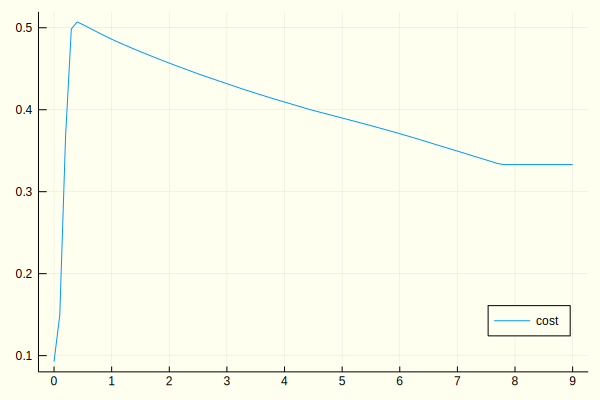

In [216]:
plot(lambda_range,ssims,label="cost",xticks = 0:1:lambda_max, background_color = :ivory, legend=:bottomright)

## Gradient Calculation
Let us consider a reduced cost function

$$
j(\lambda) = \frac{1}{2}\|S(\lambda)-z\|^2+\frac{\alpha}{2}\|\lambda\|^2,
$$

its directional derivative will be given by

$$
j'(\lambda)h = \langle S(\lambda)-z, S'(\lambda)h \rangle + \alpha \langle \lambda, h \rangle
$$

In [85]:
include("gradient_solver.jl")

gradient_solver (generic function with 1 method)

In [86]:
λ = 0.1
∇ = gradient_matrix(size(f))
u_h= lower_level_solver(u,f,λ,K)
grad = gradient_solver(u_h,z,λ,α,K,∇)

3.792123433597545

In [437]:
∇ = gradient_matrix(size(f))
K = Variation(size(f))
α = 0.1

0.1

In [62]:
step = 0.1
lambda_max = 14.0
lambda_min = 0.1
lambda_range = lambda_min:step:lambda_max
grads = Float64[]
@distributed for λ in lambda_range
    u_h = lower_level_solver(u,f,λ,K)
    g = gradient_solver(u_h,z,λ,α,K,∇)
    push!(grads,g)
    #println("$λ -> $g")
end
println("done")

done


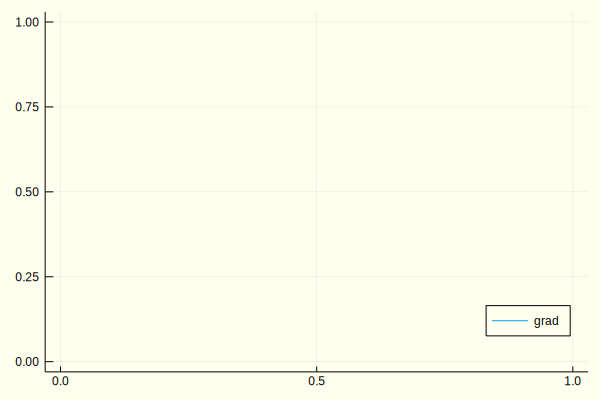

In [63]:
#plot(lambda_range,costs,label="cost",xticks = 0:1:lambda_max, background_color = :ivory, legend=:bottomright)
plot(grads,label="grad",xticks = 0:0.5:lambda_max, background_color = :ivory, legend=:bottomright)

## Trust Region Algorithm
We will use a nonsmooth trust region strategy to solve this problem. This method will consider a local quadratic model described by 

$$
q_k(s) = j(\lambda_k)+g_k^\top s + \frac{1}{2}s^\top H_k s
$$

where $s$ is the descent direction, $g_k$ will be the gradient at iteration $k$ and $H_k$ will be a matrix with second order information that can be obtained using SR1 or BFGS method.
The trust region radius will be $\Delta_k$ and the actual and predicted reductions are given by

$$
ared(s_k) := j(\lambda_k)-j(\lambda_k+s_k),\;pred(s_k) := j(\lambda_k)-q_k(s_k)
$$

and the step quality will be given by the following quotient

$$
\rho_k(s_k) = \frac{ared(s_k)}{pred(s_k)}
$$

In [320]:
include("trust_region_solver.jl")

trust_region_solver (generic function with 2 methods)

In [321]:
K = Variation(size(f))
u = Variable(size(K,1)...)
α = 1e-2

lambda_0 = 7
radius_0 = 0.05
tol = 1e-5

1.0e-5

In [318]:
model = 1
lambda_opt_1 = trust_region_solver(lower_level_solver,upper_level_cost,lambda_0,α,f,z,radius_0,tol,model)

TR Iteration 1: 	7, -0.05
lambda = 7.0, rho_k = 3.219, radius = 0.05, g_k = 22.806, s_k = -0.05, H_k = 0.0
TR Iteration 2: 	6.95, -0.07500000000000001
lambda = 6.95, rho_k = 3.07, radius = 0.075, g_k = 23.82, s_k = -0.075, H_k = 0.0
TR Iteration 3: 	6.875, -0.11250000000000003
lambda = 6.875, rho_k = 2.833, radius = 0.1125, g_k = 25.588, s_k = -0.113, H_k = 0.0
TR Iteration 4: 	6.7625, -0.16875
lambda = 6.7625, rho_k = 2.647, radius = 0.1688, g_k = 27.294, s_k = -0.169, H_k = 0.0
TR Iteration 5: 	6.59375, -0.25312500000000004
lambda = 6.5938, rho_k = 2.445, radius = 0.2531, g_k = 29.843, s_k = -0.253, H_k = 0.0
TR Iteration 6: 	6.340625, -0.37968750000000007
lambda = 6.3406, rho_k = 2.081, radius = 0.3797, g_k = 34.245, s_k = -0.38, H_k = 0.0
TR Iteration 7: 	5.9609375, -0.56953125
lambda = 5.9609, rho_k = 1.73, radius = 0.5695, g_k = 39.457, s_k = -0.57, H_k = 0.0
TR Iteration 8: 	5.39140625, -0.8542968750000001
lambda = 5.3914, rho_k = 1.441, radius = 0.8543, g_k = 44.217, s_k = -0.8

ErrorException: parameter `a` must be positive

0.40846715824324087, 68.55034023162735
0.09263425709781388, 168.0833005527697


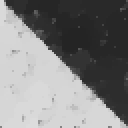

In [259]:
u_h = lower_level_solver(u,f,lambda_opt_1,K)
println("$(ssim(u_h,z)), $(upper_level_cost(u_h,z,lambda_opt_1,α))")
println("$(ssim(f,z)), $(upper_level_cost(f,z,lambda_opt_1,α))")
Gray.(u_h)

In [322]:
model = 2
lambda_opt_2 = trust_region_solver(lower_level_solver,upper_level_cost,lambda_0,α,f,z,radius_0,tol,model)

TR Iteration 1: 	7, -0.05
lambda = 7.0, rho_k = 3.219, radius = 0.05, g_k = 22.806, s_k = -0.05, H_k = -0.1
TR Iteration 2: 	 * 6.95, -0.07500000000000001
lambda = 6.95, rho_k = 3.069, radius = 0.075, g_k = 23.82, s_k = -0.075, H_k = -0.1
TR Iteration 3: 	 * 6.875, -0.11250000000000003
lambda = 6.875, rho_k = 2.832, radius = 0.1125, g_k = 25.588, s_k = -0.113, H_k = -0.1
TR Iteration 4: 	 * 6.7625, -0.16875
lambda = 6.7625, rho_k = 2.646, radius = 0.1688, g_k = 27.294, s_k = -0.169, H_k = -0.1
TR Iteration 5: 	 * 6.59375, -0.25312500000000004
lambda = 6.5938, rho_k = 2.444, radius = 0.2531, g_k = 29.843, s_k = -0.253, H_k = -0.1
TR Iteration 6: 	 * 6.340625, -0.37968750000000007
lambda = 6.3406, rho_k = 2.08, radius = 0.3797, g_k = 34.245, s_k = -0.38, H_k = -0.1
TR Iteration 7: 	 * 5.9609375, -0.56953125
lambda = 5.9609, rho_k = 1.729, radius = 0.5695, g_k = 39.457, s_k = -0.57, H_k = -0.1
TR Iteration 8: 	 * 5.39140625, -0.8542968750000001
lambda = 5.3914, rho_k = 1.44, radius = 0.85

ErrorException: parameter `a` must be positive

0.40846714842794724, 68.55034039902083
0.09263425709781388, 168.0833005527697


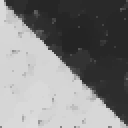

In [262]:
u_h = lower_level_solver(u,f,lambda_opt_2,K)
println("$(ssim(u_h,z)), $(upper_level_cost(u_h,z,lambda_opt_2,α))")
println("$(ssim(f,z)), $(upper_level_cost(f,z,lambda_opt_2,α))")
Gray.(u_h)

In [278]:
model = 3
lambda_opt_3 = trust_region_solver(lower_level_solver,upper_level_cost,lambda_0,α,f,z,radius_0,tol,model)

TR Iteration 1: 	rho_k = 3.241, radius = 1.0, lambda = 7.0, g_k = 22.806, s_k = -1.0, H_k = 1.0
TR Iteration 2: 	 * rho_k = 1.712, radius = 1.5, lambda = 6.0, g_k = 39.028, s_k = -1.5, H_k = 1.0
TR Iteration 3: 	 * rho_k = 1.218, radius = 2.25, lambda = 4.5, g_k = 47.125, s_k = -2.25, H_k = 1.0
TR Iteration 4: 	rho_k = -0.114, radius = 3.375, lambda = 2.25, g_k = 45.766, s_k = -2.25, H_k = 0.6
TR Iteration 5: 	 * rho_k = 0.988, radius = 1.6875, lambda = 2.25, g_k = 45.768, s_k = -1.687, H_k = 0.6
TR Iteration 6: 	rho_k = -4.197, radius = 2.5312, lambda = 0.5625, g_k = 39.817, s_k = -0.563, H_k = 10.58
TR Iteration 7: 	rho_k = -3.884, radius = 1.2656, lambda = 0.5625, g_k = 39.814, s_k = -0.563, H_k = 0.01
TR Iteration 8: 	 * rho_k = -3.884, radius = 0.6328, lambda = 0.5625, g_k = 39.814, s_k = -0.563, H_k = 0.01
TR Iteration 9: 	rho_k = 0.968, radius = 0.3164, lambda = 0.5625, g_k = 39.814, s_k = -0.316, H_k = 0.0
TR Iteration 10: 	 * rho_k = -10.008, radius = 0.4746, lambda = 0.2461, 

0.21643081413660997

0.40846715824324087, 68.55034023162735
0.09263425709781388, 168.0833005527697


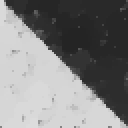

In [279]:
u_h = lower_level_solver(u,f,lambda_opt_3,K)
println("$(ssim(u_h,z)), $(upper_level_cost(u_h,z,lambda_opt_3,α))")
println("$(ssim(f,z)), $(upper_level_cost(f,z,lambda_opt_3,α))")
Gray.(u_h)

0.6938079902043084
0.5237925111569598


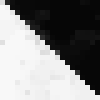

In [127]:
u_h = lower_level_solver(u,f,0.035,K)
println(ssim(u_h,z))
println(ssim(f,z))
Gray.(u_h)